In [7]:
!pip install -e ../../geoai

Obtaining file:///Users/dikaizm/Documents/PROGRAMMING/ml-ai/research-crop-mapping-thesis/geoai
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for geoai-py (pyproject.toml) ... done
  Created wheel for geoai-py: filename=geoai_py-0.17.0-0.editable-py2.py3-none-any.whl size=8024 sha256=fcbe619534400d2c1c3aeb7bfdea32ef502cba6aaf4b13689fc45b11cf195da5
  Stored in directory: /private/var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/pip-ephem-wheel-cache-u2h9fdiu/wheels/96/83/71/07d484e50b706fb043707954e5f280a67453f1002a83a09468
Successfully built geoai-py
  Attempting uninstall: geoai-py
    Found existing installation: geoai-py 0.17.0
    Uninstalling geoai-py-0.17.0:
      Successfully uninstalled geoai-py-0.17.0

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --u

### Reload Library

In [2]:
import geoai
import geoai.label_utils
import geoai.utils

import sys
sys.path.append("../")

import importlib
importlib.reload(geoai)
importlib.reload(geoai.label_utils)
importlib.reload(geoai.utils)

<module 'geoai.utils' from '/root/geoai/geoai/utils.py'>

## Data Acquisition

In [2]:
from utils import general
importlib.reload(general)

# Download s2
file_id = "1PF7umiS2qCj5yLJHGLmK1YQvQA9eCv3k"
general.download_from_gdrive(file_id, output_path="../data/raw/images/sacramento_2/S2H_2023_2023_06_30.tif")

# Download cdl
file_id = "1IshwrdrgQrtdPBVu-DXGHnuhev_hK-Zc"
general.download_from_gdrive(file_id, output_path="../data/raw/cdl/sacramento_2/2023_30m_cdls_7c_10m_remap.tif")

Downloading...
From (original): https://drive.google.com/uc?id=1PF7umiS2qCj5yLJHGLmK1YQvQA9eCv3k
From (redirected): https://drive.google.com/uc?id=1PF7umiS2qCj5yLJHGLmK1YQvQA9eCv3k&confirm=t&uuid=1abfe5c7-eb7e-4789-9193-03c90c2dea44
To: /root/research-crop-mapping-geoai/data/raw/images/sacramento_2/S2H_2023_2023_06_30.tif
100%|██████████| 5.03G/5.03G [00:54<00:00, 92.9MB/s]


✅ Downloaded: ../data/raw/images/sacramento_2/S2H_2023_2023_06_30.tif


Downloading...
From: https://drive.google.com/uc?id=1IshwrdrgQrtdPBVu-DXGHnuhev_hK-Zc
To: /root/research-crop-mapping-geoai/data/raw/cdl/sacramento_2/2023_30m_cdls_7c_10m_remap.tif
100%|██████████| 4.56M/4.56M [00:00<00:00, 12.1MB/s]

✅ Downloaded: ../data/raw/cdl/sacramento_2/2023_30m_cdls_7c_10m_remap.tif


'../data/raw/cdl/sacramento_2/2023_30m_cdls_7c_10m_remap.tif'

## Train single image

### Create subset bands

In [4]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

s2_path = "../data/raw/images/sacramento_2/S2H_2023_2023_06_30.tif"

subset = [10, 11, 5, 4, 6]  # Bands to extract

out_path = "../data/raw/images/sacramento_2/S2H_2023_2023_06_30_subset[10,11,5,4,6].tif"

with rasterio.open(s2_path) as src:
    profile = src.profile.copy()
    profile.update(count=len(subset), dtype='float64')
    with rasterio.open(out_path, "w", **profile) as dst:
        for i, b in enumerate(subset, start=1):
            dst.write(src.read(b).astype("float64"), i)

print("Saved:", out_path)

Saved: ../data/raw/images/sacramento_2/S2H_2023_2023_06_30_subset[10,11,5,4,6].tif


### Build dataset

In [3]:
import os

image_path = "../data/raw/images/sacramento_2/S2H_2023_2023_06_30_subset[10,11,5,4,6].tif"
label_path = "../data/raw/cdl/sacramento_2/2023_30m_cdls_7c_10m_remap.tif"

out_name = "single_7c_2023_06_30_subset[10,11,5,4,6]"
data_folder = f"../data/processed/{out_name}"

model_folder = f"../models/{out_name}"
os.makedirs(model_folder, exist_ok=True)

dataloader_params = {
    "tile_size": 256,
    "stride": 80,
    "skip_empty_tiles": True,
    "stats": None
}

# this function will create folders (annotations, images, labels)
tiles = geoai.export_geotiff_tiles(
    in_raster=image_path,
    out_folder=data_folder,
    in_class_data=label_path,
    tile_size=dataloader_params["tile_size"],
    stride=dataloader_params["stride"],
    buffer_radius=0,
    skip_empty_tiles=dataloader_params["skip_empty_tiles"],
)

dataloader_params["stats"] = tiles

Detected in_class_data as raster: ../data/raw/cdl/sacramento_2/2023_30m_cdls_7c_10m_remap.tif
Raster CRS: EPSG:4326
Raster dimensions: 7614 x 7503

Raster info for ../data/raw/images/sacramento_2/S2H_2023_2023_06_30_subset[10,11,5,4,6].tif:
  CRS: EPSG:4326
  Dimensions: 7614 x 7503
  Resolution: (8.983152850013118e-05, 8.983152832200529e-05)
  Bands: 5
  Bounds: BoundingBox(left=-122.073052106, bottom=38.494696387, right=-121.389074848, top=39.168702344)
Found 7 unique classes in raster: [1 2 3 4 5 6 7]


Generated: 9, With features: 9:   0%|          | 9/8556 [00:00<07:46, 18.34it/s]

Generated: 8427, With features: 8427: 100%|██████████| 8556/8556 [01:36<00:00, 89.10it/s] 


------- Export Summary -------
Total tiles exported: 8427
Tiles with features: 8427 (100.0%)
Average feature pixels per tile: 67554.2
Output saved to: ../data/processed/single_7c_2023_06_30_subset[10,11,5,4,6]

------- Georeference Verification -------


### Train DeepLabV3+ [oversampling]

#### Setup loss criterios

In [ ]:
# import torch
# from geoai import losses

# device = "cuda" if torch.cuda.is_available() else "mps"
# print("Using device:", device)

# criterion = losses.DECBLoss(
#     num_classes=11,
#     beta=0.9999,          # smoothing factor (as in paper)
#     loss_type="ce",       # or "focal"
#     gamma=2.0,            # focal gamma
#     ignore_index=255,
#     device=device
# )

Using device: mps


#### Train model

In [6]:
import mlflow
mlflow.set_tracking_uri("https://mlflow.stelarea.com")
mlflow.set_experiment("research-crop-mapping")

model_params = {
    "images_dir": f"{data_folder}/images",
    "labels_dir": f"{data_folder}/labels",
    "output_dir": f"{model_folder}/deeplabv3plus_efb5",
    "architecture": "deeplabv3plus",
    "encoder_name": "efficientnet-b5",
    "encoder_weights": None,
    "num_channels": 5,
    "num_classes": 8, # main classes + background
    "batch_size": 8,
    "num_epochs": 100,
    "learning_rate": 0.0005,
    "val_split": 0.2,
    "class_balanced": True,
    "checkpoint_interval": 5,
}

In [7]:
from pathlib import Path
import json
import torch
import time

timestamp = time.strftime("%Y%m%d-%H%M%S") 

run_name = f"{out_name}-{model_params['architecture']}-{timestamp}"

with mlflow.start_run(run_name=run_name):
    # Log parameters (avoid logging large/None weights field)
    params_to_log = {k: v for k, v in model_params.items() if k != "encoder_weights"}
    params_to_log.update({
        "image_path": image_path,
        "label_path": label_path,
        "architecture_alias": "deeplabv3plus",
        "dataloader_tile_size": dataloader_params["tile_size"],
        "dataloader_stride": dataloader_params["stride"],
        "dataloader_skip_empty_tiles": dataloader_params["skip_empty_tiles"],
        "dataloader_stats": dataloader_params["stats"],
    })
    mlflow.log_params(params_to_log)

    try:
        import mlflow.pytorch
        mlflow.pytorch.autolog(log_models=False)
    except Exception:
        pass

    # Train the segmentation model
    geoai.train_segmentation_model(
        images_dir=model_params["images_dir"],
        labels_dir=model_params["labels_dir"],
        output_dir=model_params["output_dir"],
        architecture=model_params["architecture"],
        encoder_name=model_params["encoder_name"],
        encoder_weights=model_params["encoder_weights"],
        num_channels=model_params["num_channels"],
        num_classes=model_params["num_classes"],
        batch_size=model_params["batch_size"],
        num_epochs=model_params["num_epochs"],
        learning_rate=model_params["learning_rate"],
        val_split=model_params["val_split"],
        # criterion=criterion,
        verbose=True,
        class_balanced=model_params["class_balanced"],
        save_best_only=False,
        checkpoint_interval=model_params["checkpoint_interval"],
        plot_curves=True
    )

    # Find the training output folder and history file robustly
    history_path = None
    output_dirs = set()
    # 1) user-specified output_dir
    output_dirs.add(Path(model_params["output_dir"]))
    # 2) any folder under model_folder that contains training_history.pth
    for p in Path(model_folder).rglob("training_history.pth"):
        history_path = str(p)
        output_dirs.add(p.parent)
        break

    # Log metrics from training_history.pth if present
    if history_path and Path(history_path).exists():
        try:
            history = torch.load(history_path, map_location="cpu")
            keys = [
                'train_losses', 'val_losses', 'val_ious', 'val_f1s',
            ]
            max_len = max(len(history.get(k, [])) for k in keys if isinstance(history.get(k, []), (list, tuple)) ) if history else 0
            for epoch in range(max_len):
                metrics = {}
                for k in keys:
                    seq = history.get(k, [])
                    if isinstance(seq, (list, tuple)) and epoch < len(seq):
                        try:
                            metrics[k] = float(seq[epoch])
                        except Exception:
                            pass
                if metrics:
                    mlflow.log_metrics(metrics, step=epoch + 1)
        except Exception as e:
            print("Could not parse training history for MLflow metrics:", e)

Using device: cuda
Found 8427 image files and 8427 label files
Training on 6741 images, validating on 1686 images
Checking image sizes for compatibility...
All sampled images have the same size: (256, 256)
No resizing needed.
Building class-balanced sampler (strategy='presence') ...
Class-balanced sampler ready. Non-empty classes: 8/8.
Class balanced sampler: <torch.utils.data.sampler.WeightedRandomSampler object at 0x75d5746736d0>
Using class balanced sampler
Testing data loader...
Data loader test passed.
Starting training with deeplabv3plus + efficientnet-b5
Model parameters: 29,495,080
Epoch: 1, Batch: 1/842, Loss: 2.0816, Time: 2.71s
Epoch: 1, Batch: 11/842, Loss: 1.5798, Time: 0.80s
Epoch: 1, Batch: 21/842, Loss: 1.2806, Time: 0.72s
Epoch: 1, Batch: 31/842, Loss: 1.2461, Time: 0.75s
Epoch: 1, Batch: 41/842, Loss: 1.4165, Time: 0.74s
Epoch: 1, Batch: 51/842, Loss: 1.2987, Time: 0.75s
Epoch: 1, Batch: 61/842, Loss: 1.1725, Time: 0.77s
Epoch: 1, Batch: 71/842, Loss: 1.5282, Time: 0.

#### Plot model perf

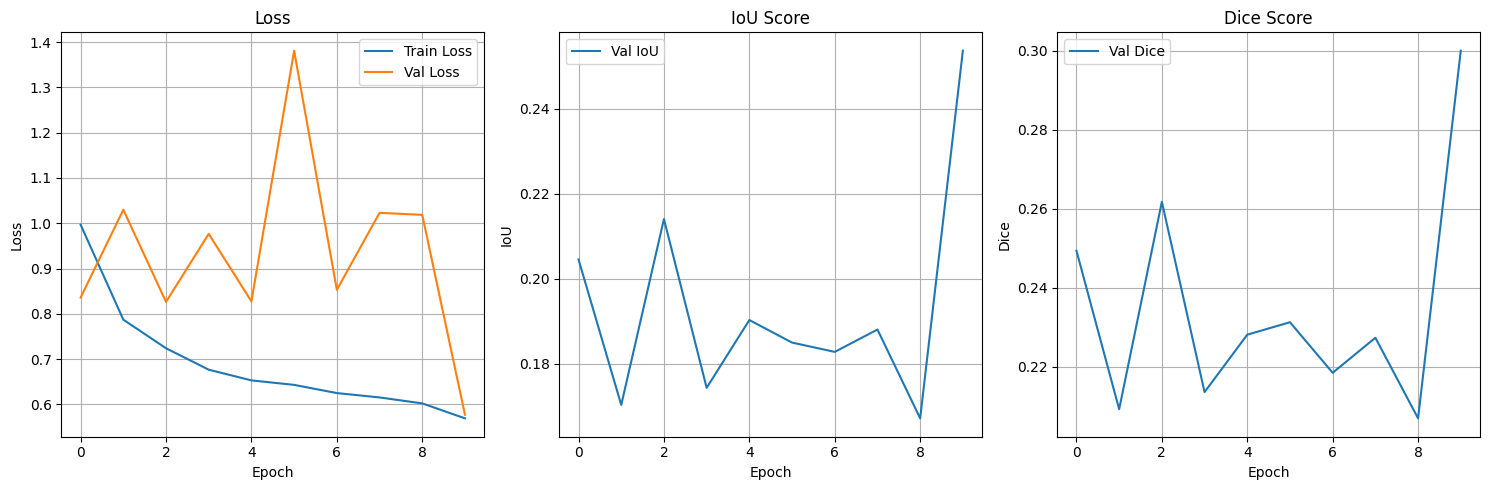

Best IoU: 0.2537
Final IoU: 0.2537
Best Dice: 0.3000
Final Dice: 0.3000


In [8]:
geoai.plot_performance_metrics(
    history_path=f"{model_params['output_dir']}/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

#### Run inference

In [9]:
# Define paths
model_path = f"{model_params['output_dir']}/best_model.pth"
test_raster_path = "../data/raw/images/S2H_2024_2024_07_29_nodata.tif"
predicted_path = f"../data/predicted/{out_name}/S2H_2024_2024_07_29_pred.tif"

# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=predicted_path,
    model_path=model_path,
    architecture=model_params["architecture"],
    encoder_name=model_params["encoder_name"],
    num_channels=model_params["num_channels"],
    num_classes=model_params["num_classes"],
    window_size=dataloader_params["tile_size"],
    overlap=dataloader_params["stride"],
    batch_size=8,
)

Input file format: GeoTIFF (.tif)
Processing 1271 windows...


1344it [00:24, 55.31it/s]                          


Predicted classes: 6 classes, Background: 51.4%
Inference completed in 31.30 seconds
Saved prediction to ../data/predicted/single_7c_2023_06_30/S2H_2024_2024_07_29_pred.tif


#### Remap class pred

In [ ]:
from geoai import label_utils

# Map them into compact range
mapping = {
    0: 0,   # Background
    1: 1,   # Corn
    3: 2,   # Rice
    24: 3,  # Winter Wheat
    54: 4,  # Tomatoes
    69: 5,  # Grapes
    75: 5,  # Almonds
    76: 6,  # Walnuts
}

# Remap back to original class codes
label_utils.remap_back_raster(
    in_path=predicted_path,
    out_path=predicted_path.replace(".tif", "_remap.tif"),
    mapping=mapping
)

Unique compact values in prediction: [0 1 2 3 4 5 6]
Saved restored raster to ../data/predicted/single_6c_2023_07_30/S2H_2024_2024_07_29_pred_remap.tif
Unique values: [ 0  1  3 24 54 75 76]


#### Visualize pred

In [16]:
import sys
sys.path.append("../")
from utils.constants import USDA_CDL_COLORS

geoai.view_raster_with_labels(
    raster_image=test_raster_path,
    label_raster=predicted_path,
    class_mapping={
        0: "Background",
        1: "Corn",
        3: "Rice",
        24: "Winter Wheat",
        54: "Tomatoes",
        69: "Grapes",
        75: "Almonds",
        76: "Walnuts",
    },
    class_colors={
        0: USDA_CDL_COLORS.get(0),
        1: USDA_CDL_COLORS.get(1),
        3: USDA_CDL_COLORS.get(3),
        24: USDA_CDL_COLORS.get(24),
        54: USDA_CDL_COLORS.get(54),
        69: USDA_CDL_COLORS.get(69),
        75: USDA_CDL_COLORS.get(75),
        76: USDA_CDL_COLORS.get(76),
    },
    raster_indexes=(3, 2, 1),
    raster_layer_name="Satellite",
    label_layer_name="Labels",
    legend_title="Crop Classes",
    opacity=0.5,
)

Map(center=[38.929975, -121.751141], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…